## How to calculate time dependence of quaternion by angular velocity

2020/05/02 Kosuke Maeda

This scripts shows the algorithm to calculate time dependence of quaternion by angular velocity for the application to determine the attitude of machine by 3-axis gyro sensor. The step of algorithm is shown here.

1. Set time step $dt$ [s]. $dt$ is the output cycle of gyro sensor for actual situation. For simulation, let us set several values (i.e. 0.1 to 1.0 sec) and see the result and optimize it by yourself.
1. Define time dependence of angular velocity $\omega$. $\omega = \omega(t)$ is the output of gyro sensor for actual. For simulation, let us define simple dynamics like uniform motion.
1. Set initial quaternion $q = (q_w\;q_x\;q_y\;q_z)^T$ at $t = 0$. $q = q(t)$ is the attitude of gyro sensor for actual.
1. Solve ordinary differential equation $\dot q = \cfrac{1}{2}\Omega q$ by Runge-Kutta method. $\Omega$ is 4x4 matrix consists of angular velocity $\mathbf \omega = (\omega_x\;\omega_y\;\omega_z)^T$.
$$ \Omega =
    \begin{pmatrix}
    0 & -\omega_x & -\omega_y & -\omega_z \\
    \omega_x & 0 & \omega_z & -\omega_y \\
    \omega_y & -\omega_z & 0 & \omega_x \\
    \omega_z & \omega_y & -\omega_x & 0 \\
    \end{pmatrix}
$$

### Preparation
- sudo apt install python3-pip
- pip3 install numpy
- pip3 install pandas
- pip3 install matplotlib
- pip3 install numpy-quaternion

In [333]:
from copy import deepcopy
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d  # for 3d plot
import quaternion

### Settings

In [334]:
df = pd.DataFrame()

# time [s]
tstart = 0
tend = 60.0
dt = 0.1
df['t'] = np.arange(tstart, tend + dt, dt)

# angular velocity [rad/s]
# let us assume simple dynamics; uniform angular velocity motion at z-axis
df['wx'] = 0
df['wy'] = 0
df['wz'] = 2 * np.pi / 60
# 360 deg rotation in 1 min, so 6 deg/s rotation --> 0.6 deg per dt
# we need to set dt making <1.0 deg/dt to get better simulation precision

# initial quaternion
df['qw'] = np.nan
df['qx'] = np.nan
df['qy'] = np.nan
df['qz'] = np.nan
df.loc[0, 'qw'] = 1
df.loc[0, 'qx'] = 0
df.loc[0, 'qy'] = 0
df.loc[0, 'qz'] = 0

# see data frame now
df
# NaN means brank cell and to fill by simulation

,t,wx,wy,wz,qw,qx,qy,qz
0,0.0,0,0,0.10472,1.0,0.0,0.0,0.0
1,0.1,0,0,0.10472,NaN,NaN,NaN,NaN
2,0.2,0,0,0.10472,NaN,NaN,NaN,NaN
3,0.3,0,0,0.10472,NaN,NaN,NaN,NaN
4,0.4,0,0,0.10472,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
596,59.6,0,0,0.10472,NaN,NaN,NaN,NaN
597,59.7,0,0,0.10472,NaN,NaN,NaN,NaN
598,59.8,0,0,0.10472,NaN,NaN,NaN,NaN
599,59.9,0,0,0.10472,NaN,NaN,NaN,NaN


### Simulation: solve quaternion and angular velocity eq. by Runge-Kutta method

In [335]:
# q(t) expression when coordinate system is rotating
# w: angular velocity vector at t=t. np.array([wx, wy, wz])
# q: quaternion at t=t. np.array([qw, qx, qy, qz])
# return: dq/dt. np.array(qw/dt, qx/dt, qy/dt, qz/dt)
def dqdt(w, q):
    wx = w[0]
    wy = w[1]
    wz = w[2]
    w_mat = np.array([
        [0,  -wx, -wy, -wz],
        [wx,   0,  wz, -wy],
        [wy, -wz,   0,  wx],
        [wz,  wy, -wx,   0]
    ])
    return 0.5 * np.dot(w_mat, q)

In [336]:
# solve dqdt() by Runge-Kutta method
q = np.array([df.loc[0, 'qw'], df.loc[0, 'qx'], df.loc[0, 'qy'], df.loc[0, 'qz']])
for i in range(len(df)):
    if i == 0:
        continue
    # w_: angular velocity at t = t - dt
    # q_: quaternion at t = t - dt
    # w: angular velocity at t = t (now)
    # q: quaternion at t = t
    w_ = np.array([df.loc[i-1, 'wx'], df.loc[i-1, 'wy'], df.loc[i-1, 'wz']])
    w = np.array([df.loc[i, 'wx'], df.loc[i, 'wy'], df.loc[i, 'wz']])
    q_ = deepcopy(q)

    # first modification
    k1 = dqdt(w_, q_)
    q = q_ + 0.5 * dt * k1
    # second modification
    k2 = dqdt(0.5 * (w_ + w), q)
    q = q_ + 0.5 * dt * k2
    # third modification
    k3 = dqdt(0.5 * (w_ + w), q)
    q = q_ + dt * k3
    # fourth modification
    k4 = dqdt(w, q)
    q = q_ + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)
    
    #q = q_ + dqdt(w_, q_) * dt  # how about compare with rectangular integration cause not-better simulation precision
    # you can use quaternion.integrate_angular_velocity() instead of own Runge-Kutta

    # store the result
    df.loc[i, 'qw'] = q[0]
    df.loc[i, 'qx'] = q[1]
    df.loc[i, 'qy'] = q[2]
    df.loc[i, 'qz'] = q[3]

<IPython.core.display.Javascript object>


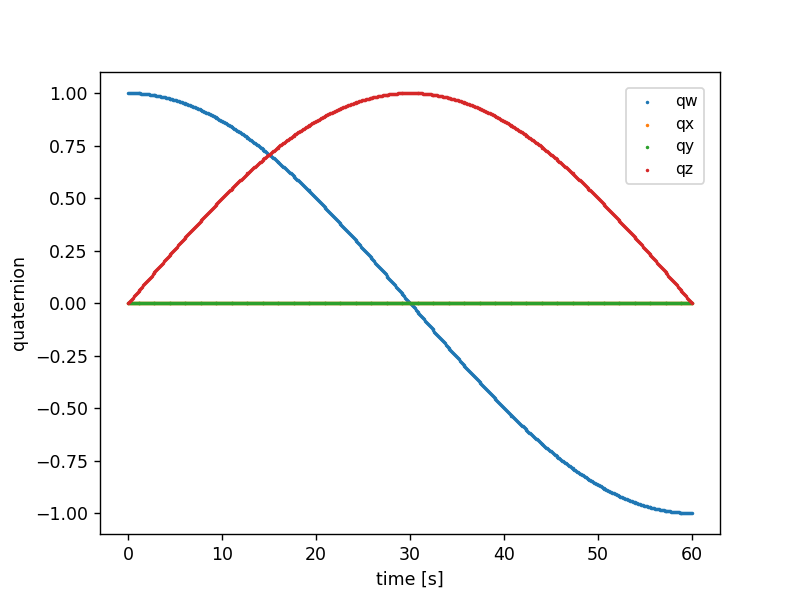

In [337]:
# visualize quaternion
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(df.t, df.qw, s=1, label='qw')
ax.scatter(df.t, df.qx, s=1, label='qx')
ax.scatter(df.t, df.qy, s=1, label='qy')
ax.scatter(df.t, df.qz, s=1, label='qz')
ax.set_xlabel('time [s]')
ax.set_ylabel('quaternion')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=9)
plt.show()

### Verification of the simulation: norm(q) and angle(q)

In [338]:
# add norm(q) and angle(q) to data frame
def check_quaternion(df):
    norms = []
    angles = []
    for i in range(len(df)):
        qw = df.loc[i, 'qw']
        qx = df.loc[i, 'qx']
        qy = df.loc[i, 'qy']
        qz = df.loc[i, 'qz']
        q = np.quaternion(qw, qx, qy, qz)
        norms.append(q.norm())
        angles.append(q.angle())
    df['q_norm'] = norms
    df['q_angle'] = angles

In [339]:
# to check mean(q_norm) = 1.000000 and std(q_norm) = 0.0000001
check_quaternion(df)
df.describe()

,t,wx,wy,wz,qw,qx,qy,qz,q_norm,q_angle
count,601.000000,601.0,601.0,6.010000e+02,6.010000e+02,601.0,601.0,601.000000,6.010000e+02,601.000000
mean,30.000000,0.0,0.0,1.047198e-01,6.270841e-12,0.0,0.0,0.635559,1.000000e+00,3.141593
std,17.363803,0.0,0.0,1.388935e-17,7.082843e-01,0.0,0.0,0.308855,4.981595e-14,1.818333
min,0.000000,0.0,0.0,1.047198e-01,-1.000000e+00,0.0,0.0,0.000000,1.000000e+00,0.000000
25%,15.000000,0.0,0.0,1.047198e-01,-7.071068e-01,0.0,0.0,0.382683,1.000000e+00,1.570796
50%,30.000000,0.0,0.0,1.047198e-01,9.839134e-12,0.0,0.0,0.707107,1.000000e+00,3.141593
75%,45.000000,0.0,0.0,1.047198e-01,7.071068e-01,0.0,0.0,0.923880,1.000000e+00,4.712389
max,60.000000,0.0,0.0,1.047198e-01,1.000000e+00,0.0,0.0,1.000000,1.000000e+00,6.283185


<IPython.core.display.Javascript object>


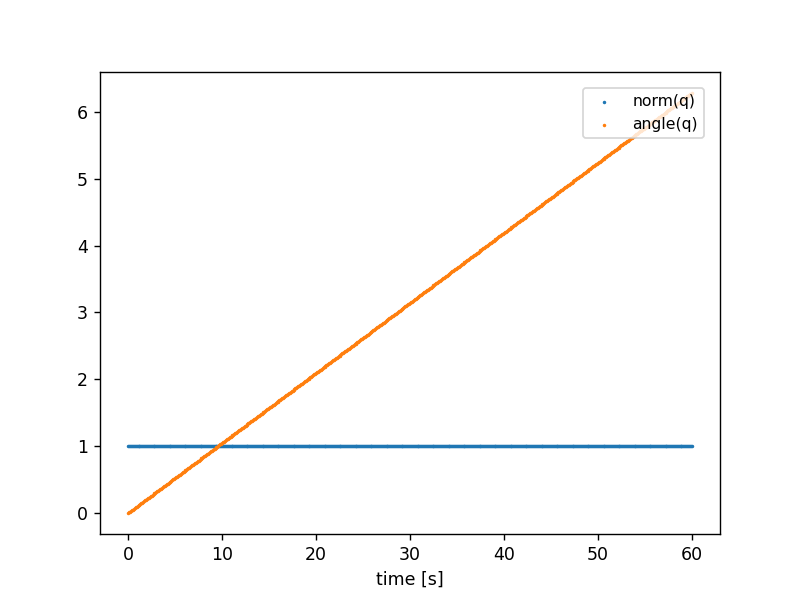

In [340]:
# visualize quaternion summary
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(df.t, df.q_norm, s=1, label='norm(q)')
ax.scatter(df.t, df.q_angle, s=1, label='angle(q)')
ax.set_xlabel('time [s]')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=9)
plt.show()

Make sure mean(q_norm) = 1.000000 and small std(q_norm). And angle(q) curves line as we expected that would linear change 0 to 2$\pi$ in this case.

<IPython.core.display.Javascript object>


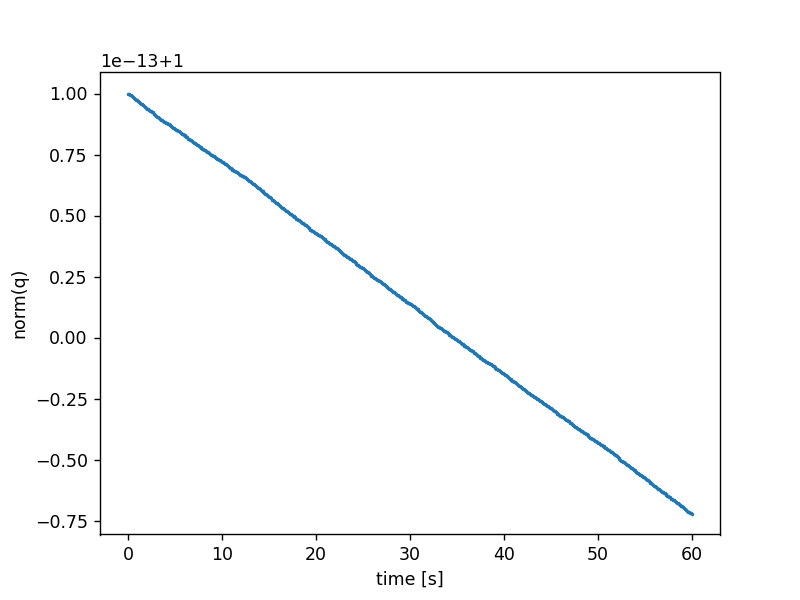

In [341]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(df.t, df.q_norm, s=1)
ax.set_xlabel('time [s]')
ax.set_ylabel('norm(q)')
plt.show()

norm(q) is going down slowly under the enought high precision.

### Verification of the simulation: rotate vector by quaternion

In [342]:
origin = np.array([0, 0, 0])
v0 = np.array([1, 1, 1])  # rotation target vector at t = 0
vt = []
for index, row in df[::20].iterrows(): 
    q = np.quaternion(row.qw, row.qx, row.qy, row.qz)
    v = quaternion.rotate_vectors(q, v0)
    v_ = np.concatenate((origin, v))
    vt.append(v_)

<IPython.core.display.Javascript object>


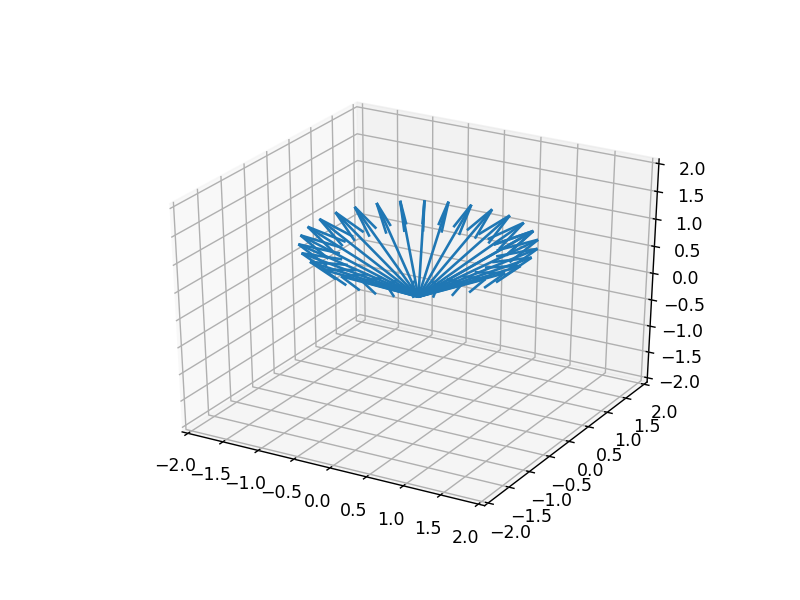

In [343]:
soa = np.array(vt)
X, Y, Z, U, V, W = zip(*soa)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W)
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])
plt.show()
# ref. https://stackoverflow.com/questions/27023068/plotting-3d-vectors-using-matplot-lib

### Reference

In Japanese references

- クォータニオン (Quaternion) を総整理！ ～ 三次元物体の回転と姿勢を鮮やかに扱う ～ - Qiita https://qiita.com/drken/items/0639cf34cce14e8d58a5
- PythonでQuaternionを使う ~ numpy-quaternion ~ - Qiita https://qiita.com/momomo_rimoto/items/3a245736c5fd90fe8270
- クォータニオン計算便利ノート https://www.mss.co.jp/technology/report/pdf/18-07.pdf